In [1]:
## Get the data
library("AzureML")
ws <- workspace()
dat <- download.datasets(ws, "calls_census_tracts.csv")

In [2]:
## Preview the data
head(dat)

,CaseID,Opened,Closed,Updated,Status,Status.Notes,Responsible.Agency,Category,Request.Type,Request.Details,â¯,Source,Media.URL,shape_area,nhood,tractce10,geoid,shape_len,coords.x1,coords.x2,optional
1,5669509,03/16/2016 12:55:50 AM,,03/16/2016 12:57:23 AM,Open,accepted,Recology_Abandoned,Street and Sidewalk Cleaning,Bulky Items,Mattress,,Voice In,,6096737,Castro/Upper Market,20600,6075020600,10051.4,-122.4308,37.76126,TRUE
2,5669507,03/16/2016 12:45:35 AM,,03/16/2016 12:47:14 AM,Open,open,DPW BSM Queue,Sidewalk or Curb,Sidewalk_Defect,Collapsed_sidewalk,,Voice In,,998560.9,Tenderloin,12202,6075012202,4038.012,-122.4184,37.78679,TRUE
3,5669497,03/16/2016 12:24:19 AM,,03/16/2016 12:31:57 AM,Open,open,DPW BSM Queue,Street Defects,Construction_Plate_Shifted,Construction_Plate_Shifted,,Voice In,,2303726,South of Market,17801,6075017801,6173.165,-122.4012,37.78202,TRUE
4,5669495,03/16/2016 12:21:12 AM,,03/16/2016 12:22:26 AM,Open,accepted,Recology_Abandoned,Street and Sidewalk Cleaning,Bulky Items,Mattress,,Voice In,,989799.4,Tenderloin,12401,6075012401,3978.002,-122.4161,37.78409,TRUE
5,5669490,03/16/2016 12:16:40 AM,,03/16/2016 12:16:43 AM,Open,open,DPW Ops Queue,Graffiti Public Property,Not_Offensive Graffiti on Public Property,Signal_box - Not_Offensive,,Open311,,989799.4,Tenderloin,12401,6075012401,3978.002,-122.4161,37.78445,TRUE
6,5669489,03/16/2016 12:14:19 AM,,03/16/2016 12:14:19 AM,Open,accepted,Recology_Abandoned,Street and Sidewalk Cleaning,Bulky Items,Furniture,,Open311,,1327996,Nob Hill,12100,6075012100,5234.012,-122.4119,37.78911,TRUE


In [3]:
# Install Forecast. Doesn't seem to persist in Azure ML Studio.
install.packages("forecast")

Installing package into '/home/nbcommon/R'
(as 'lib' is unspecified)
also installing the dependencies 'timeDate', 'tseries', 'fracdiff', 'RcppArmadillo'




The downloaded source packages are in
	'/tmp/RtmpYkaN6N/downloaded_packages'


In [4]:
# Load libraries
library(forecast)
library(ggplot2)
library(dplyr)
library(stats)

Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Loading required package: timeDate
This is forecast 6.1 


Attaching package: 'dplyr'

The following object is masked from 'package:stats':

    filter

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



In [5]:
## Freq table of requests by Category.
req_counts <- data.frame(table(dat$Category))
req_counts <- req_counts[order(-req_counts$Freq),]
top5req <- req_counts[1:5,]
print(top5req)

                           Var1   Freq
24 Street and Sidewalk Cleaning 560251
11     Graffiti Public Property 154242
10    Graffiti Private Property 122313
2             Abandoned Vehicle 118189
9              General Requests  96821


In [6]:
# Format 'Opened' field to Posix, then Date.
dat$Opened <- as.POSIXct(strptime(dat$Opened, format = "%m/%d/%Y %I:%M:%S %p"), tz = "America/Los_Angeles")
dat$Opened <- as.Date(dat$Opened)

# Preview
head(dat$Opened)

[1] "2016-03-16" "2016-03-16" "2016-03-16" "2016-03-16" "2016-03-16"
[6] "2016-03-16"

In [7]:
# Subset to only those cases of the top 5 request categories.
cases_top5q <- dat[dat$Category %in% top5req$Var1,]

# Preview
print(head(cases_top5q, 3))

   CaseID     Opened Closed                Updated Status Status.Notes
1 5669509 2016-03-16        03/16/2016 12:57:23 AM   Open     accepted
4 5669495 2016-03-16        03/16/2016 12:22:26 AM   Open     accepted
5 5669490 2016-03-16        03/16/2016 12:16:43 AM   Open         open
  Responsible.Agency                     Category
1 Recology_Abandoned Street and Sidewalk Cleaning
4 Recology_Abandoned Street and Sidewalk Cleaning
5      DPW Ops Queue     Graffiti Public Property
                               Request.Type            Request.Details
1                               Bulky Items                   Mattress
4                               Bulky Items                   Mattress
5 Not_Offensive Graffiti on Public Property Signal_box - Not_Offensive
                                   Address Supervisor.District Neighborhood
1 496 SANCHEZ ST, SAN FRANCISCO, CA, 94114                   8       Castro
4    345 HYDE ST, SAN FRANCISCO, CA, 94109                   6   Tenderloin
5   

In [8]:
# View tail: Please note how those in the top 5 didn't start till 7/1/2008 (the data set is in descending
# chronological order). This is important to our time series considerations.
print(tail(cases_top5q, 3))

        CaseID     Opened                 Closed                Updated Status
1594506 240222 2008-07-01 07/01/2008 06:10:00 AM 07/01/2008 06:10:00 AM Closed
1594507 240221 2008-07-01 07/08/2008 10:03:00 AM 07/08/2008 10:03:00 AM Closed
1594509 240216 2008-07-01 07/01/2008 06:10:00 AM 07/01/2008 06:10:00 AM Closed
        Status.Notes                Responsible.Agency
1594506                                  DPW Ops Queue
1594507              DPT Abandoned Vehicles Work Queue
1594509                                  DPW Ops Queue
                            Category                 Request.Type
1594506 Street and Sidewalk Cleaning            Sidewalk_Cleaning
1594507            Abandoned Vehicle Abandoned Vehicle - Car4door
1594509 Street and Sidewalk Cleaning              Illegal_Dumping
                                     Request.Details
1594506                                      Garbage
1594507 DARK BLUE - FORD - CROWN VICTORIA  - 3WBG858
1594509                                  

In [9]:
## Create a dataframe of all days, sequencing between first opened day to last. 
## Then change the first column's name to 'Var1' for later joining.
##
## This is because some days don't have any recorded requests for a given category, but proper
## time-series analyses require at least '0's for such days.
alldays <- as.data.frame(seq(tail(dat$Opened,1), head(dat$Opened,1), by = "day"))
names(alldays)[1] <- "Var1"

In [10]:
head(alldays)

,Var1
1,2008-03-20
2,2008-03-21
3,2008-03-22
4,2008-03-23
5,2008-03-24
6,2008-03-25


In [11]:
## Get counts per top 5 category
cat_counts <- data.frame(table(dat$Category))
cat_counts <- cat_counts[order(-cat_counts$Freq),]
top5cat <- cat_counts[1:5,]

## Subset cases by top 5 category.
cases_top5c <- dat[dat$Category %in% top5cat$Var1,]

## Loop through creating freq DFs.
top5_freqs <- vector()
for(i in 1:5){
    cat_sub <- cases_top5c[cases_top5c$Category %in% top5cat$Var1[i],]
    cat_freq <- data.frame(table(cat_sub$Opened))
    cat_freq$Var1 <- as.Date(cat_freq$Var1)
    cat_freq <- right_join(cat_freq, alldays, by = "Var1")
    cat_freq$Freq[is.na(cat_freq$Freq)] <- 0
    names(cat_freq)[1] <- "Date"
    
    top_rank <- paste0("cat",i,"_freq")
    assign(top_rank, cat_freq)
    
    # Catching DF names for later use.
    top5_freqs <- append(top5_freqs, top_rank)
}

## Preview/test
paste("Rows in No. 1 category freq table:", nrow(cat1_freq))
paste("Rows in No. 5 category freq table:", nrow(cat5_freq))
head(cat1_freq[cat1_freq$Date >= "2008-07-01",])
head(cat5_freq[cat5_freq$Date >= "2008-07-01",])

[1] "Rows in No. 1 category freq table: 2919"

[1] "Rows in No. 5 category freq table: 2919"

,Date,Freq
104,2008-07-01,171
105,2008-07-02,212
106,2008-07-03,143
107,2008-07-04,107
108,2008-07-05,84
109,2008-07-06,97


,Date,Freq
104,2008-07-01,0
105,2008-07-02,0
106,2008-07-03,0
107,2008-07-04,1
108,2008-07-05,1
109,2008-07-06,1


In [12]:
## Loop through creating daily, weekly, and monthly TS objects per top 5 category.
for(i in 1:5){
    # Subset to span of 7/1/08 -> 3/1/16, because these categories aren't really recorded until 7/1/08.
    # We can probably just comment this line out later...
    current_cat <- get(top5_freqs[i])
    ts_sub <- current_cat[current_cat$Date >= "2008-07-01" & current_cat$Date < "2016-03-01",]
    
    # Create daily time series
    cat_ts_day <- ts(ts_sub$Freq, frequency = 365)
    
    # Name daily ts by index in loop
    ts_rank_day <- paste0("cat",i,"_ts_day")
    assign(ts_rank_day, cat_ts_day)
    
    # Weekly time series
    cat_freq_w <- summarise(group_by(ts_sub, format(ts_sub$Date, "%Y%W")), Freq = sum(Freq))
    names(cat_freq_w)[1] <- "Y.Week"
    cat_ts_week <- ts(cat_freq_w$Freq, frequency = 53)
    
    # Name weekly ts by index in loop
    ts_rank_week <- paste0("cat",i,"_ts_week")
    assign(ts_rank_week, cat_ts_week)
    
    # Monthly time series
    cat_freq_m <- summarise(group_by(ts_sub, format(ts_sub$Date, "%Y%m")), Freq = sum(Freq))
    names(cat_freq_m)[1] <- "Y.Month"
    cat_ts_month <- ts(cat_freq_m$Freq, frequency = 12)
    
    # Name monthly ts by index in loop
    ts_rank_month <- paste0("cat",i,"_ts_month")
    assign(ts_rank_month, cat_ts_month)
    
}

## Test and preview
length(cat1_ts_day)
head(cat1_ts_day)
tail(cat1_ts_day)

length(cat3_ts_week)
head(cat3_ts_week)
tail(cat3_ts_week)

length(cat5_ts_month)
head(cat5_ts_month)
tail(cat5_ts_month)

[1] 2800

[1] 171 212 143 107  84  97

[1] 565 536 531 402 415 618

[1] 409

[1] 124 144 145 167 174 145

[1] 525 589 508 432 590  85

[1] 92

[1]  48 169 237 450 459 495

[1] 1592 2397 2146 2225 2274 2017

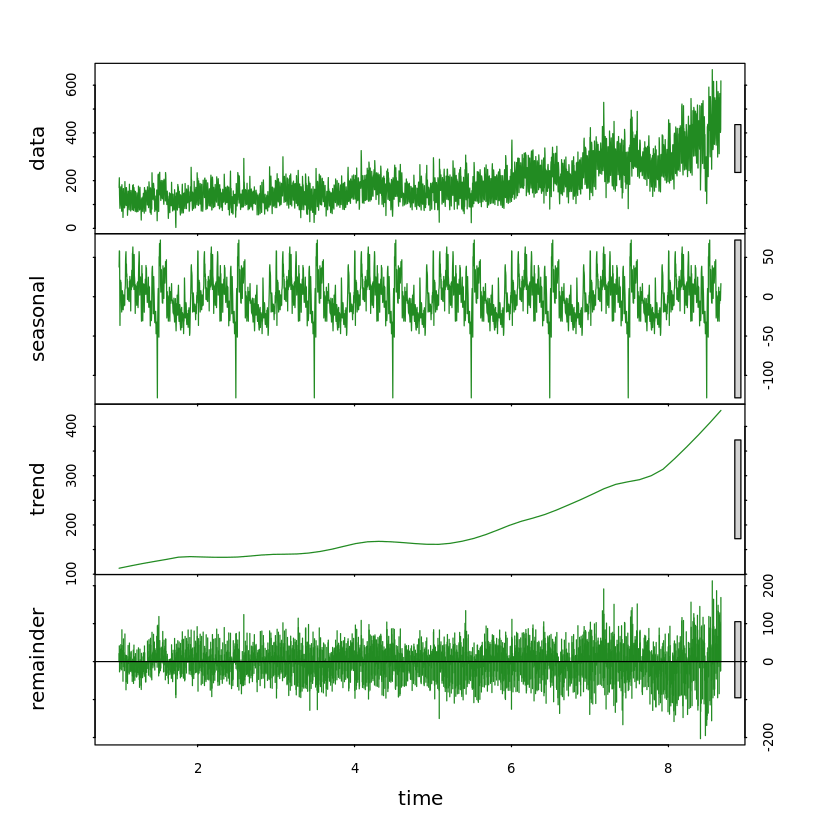

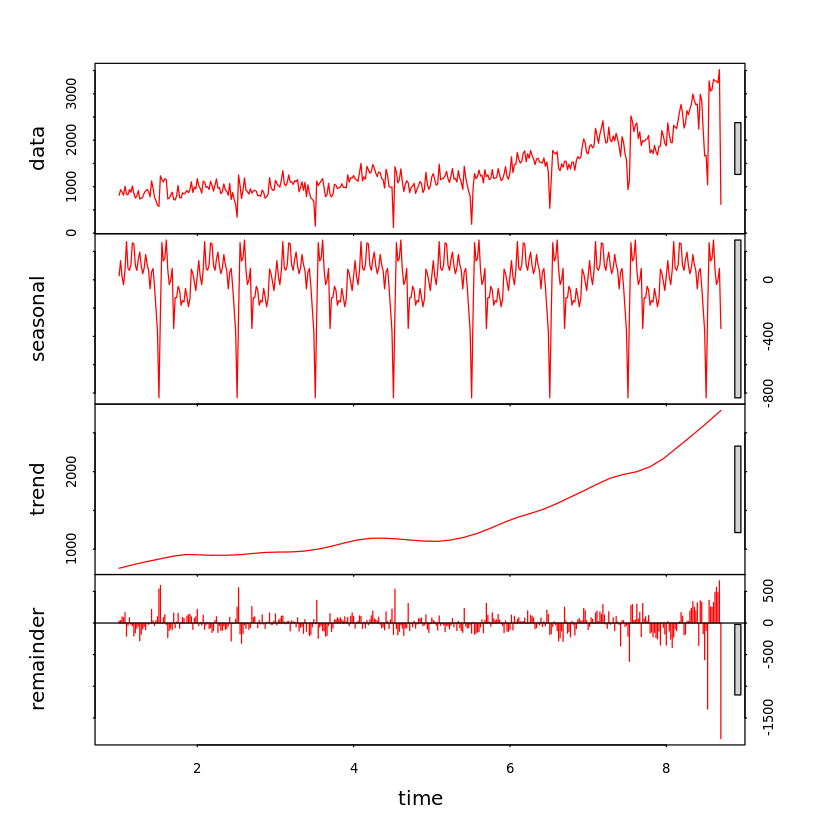

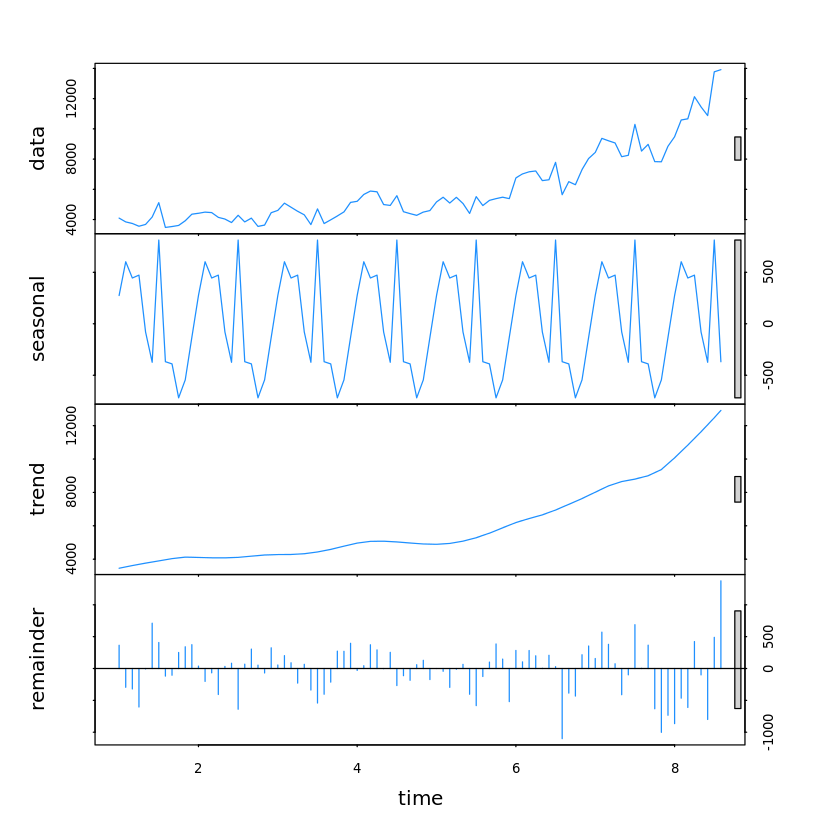

In [13]:
# Quick seasonal decomp via STL method. Might not be optimal, but probably good for exploration.
# More on stl and Loess: http://align-alytics.com/seasonal-decomposition-of-time-series-by-loessan-experiment/
# More on forecasting from decomposition: https://www.otexts.org/fpp/6/6

# This is by year, btw (with 365 days within each year).
plot(stl(cat1_ts_day, s.window = "periodic"), col = "forestgreen")

# Also by year (with 53 weeks within each year).
plot(stl(cat1_ts_week, s.window = "periodic"), col = "red")

# Also by year (with 12 months within each year).
plot(stl(cat1_ts_month, s.window = "periodic"), col = "dodgerblue")

In [14]:
## Install and invoke Anamoly Detection package via Devtools
install.packages("devtools")

Installing package into '/home/nbcommon/R'
(as 'lib' is unspecified)



The downloaded source packages are in
	'/tmp/RtmpYkaN6N/downloaded_packages'


In [15]:
library(devtools)
devtools::install_github("twitter/AnomalyDetection")

Installing AnomalyDetection
Installing 9 packages: RColorBrewer, colorspace, digest, ggplot2, labeling, lubridate, plyr, reshape2, scales
Installing packages into '/home/nbcommon/R'
(as 'lib' is unspecified)



The downloaded source packages are in
	'/tmp/RtmpYkaN6N/downloaded_packages'


'/usr/lib/R/bin/R' --no-site-file --no-environ --no-save --no-restore CMD  \
  INSTALL  \
  '/tmp/RtmpYkaN6N/devtools8016c34039/twitter-AnomalyDetection-1f5deaa'  \
  --library='/home/nbcommon/R' --install-tests 



In [16]:
library(AnomalyDetection)

In [22]:
## Grab a test category full of data.
top1_cat <- get(top5_freqs[1])

## Subset to cases from two years prior to the user's query date (presumably, today).
cat1_df <- top1_cat[top1_cat$Date >= (Sys.Date() - 730),]

## Preview
head(cat1_df)
dim(cat1_df)

,Date,Freq
2264,2014-05-31,212
2265,2014-06-01,246
2266,2014-06-02,365
2267,2014-06-03,378
2268,2014-06-04,324
2269,2014-06-05,278


[1] 656   2

In [29]:
## Anomaly detection package only accepts POSIXct, so let's convert to that.
cat1_df$Date <- as.POSIXct(strptime(cat1_df$Date, "%Y-%m-%d"))
class(cat2_df$Date)

[1] "POSIXct" "POSIXt"

In [26]:
head(cat1_df)
tail(cat1_df)

,Date,Freq
2264,2014-05-31,212
2265,2014-06-01,246
2266,2014-06-02,365
2267,2014-06-03,378
2268,2014-06-04,324
2269,2014-06-05,278


,Date,Freq
2914,2016-03-11,362
2915,2016-03-12,316
2916,2016-03-13,202
2917,2016-03-14,459
2918,2016-03-15,471
2919,2016-03-16,112


   timestamp anoms
1 2016-01-20   665
2 2016-01-26   616
3 2016-02-09   616
4 2016-02-29   618
5 2016-03-01   687
6 2016-03-02   649


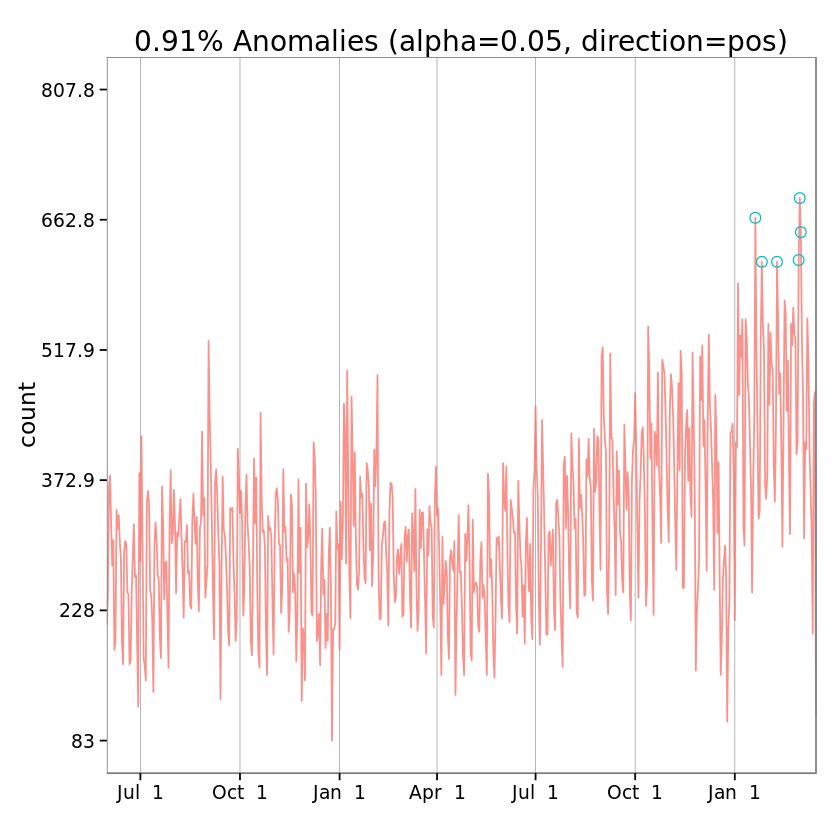

In [27]:
## Detect anomalies but only in the positive direction (not sure how useful the negative direction would be).
res <- AnomalyDetectionTs(cat1_df, max_anoms=0.05, direction='pos', plot=TRUE)
res$plot
print(res$anom)

In [28]:
## Is/was today or yesterday anomolous? I check for today or yesterday in case there are -or aren't- yet enough
## cases to do a proper check of today.
today_anom <- grepl(Sys.Date(), tail(res$anom$timestamp, 2))
print(today_anom)

[1] FALSE FALSE
